In [26]:
using VegaLite
using PlotlyJS
include("./utils.jl")
include("./unit_commitment.jl")
include("./plotting.jl")
ENV["COLUMNS"]=120 # Set so all columns of DataFrames and Matrices are displayed

color_map=Dict(
    "battery" => "green",
    "solar_photovoltaic" => "gold",
    "onshore_wind_turbine" => "skyblue",
    "hydroelectric_pumped_storage" => "darkblue",
    "small_hydroelectric" => "cornflowerblue",
    "biomass" => "#6fc276",
    "natural_gas_fired_combined_cycle" => "grey",
    "natural_gas_fired_combustion_turbine" => "black",
    "total" => "purple",
    "required" => "#F0092",
)
color_discrete_map = (key) -> if haskey(color_map, key) color_map[key] else "red" end
map_stack_group = (x, exclude) -> 1*(x != exclude) + 2*(x == exclude)

#491 (generic function with 1 method)

In [28]:

gen_info, fuels, loads, gen_variable_info, storage_info = read_data()
gen_df = pre_process_generators_data(gen_info, fuels)
storage_df = pre_process_storage_data(storage_info)

# A spring day
n=100
T_period = (n*24+1):((n+1)*24)

# High solar case: 3,500 MW
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500
gen_variable = pre_process_gen_variable(gen_df_sens, gen_variable_info)

# Filtering data with timeseries according to T_period
gen_variable_multi = gen_variable[in.(gen_variable.hour,Ref(T_period)),:];
loads_multi = loads[in.(loads.hour,Ref(T_period)),:];

required_reserve = DataFrame(
    hour = loads[in.(loads.hour, Ref(T_period)), :hour],
    reserve_up_MW = 300 .+ loads[in.(loads.hour,Ref(T_period)), :demand].*0.05,
    reserve_down_MW = loads[in.(loads.hour, Ref(T_period)), :demand].*0.05)
;





### Base configuration
Unit commitment with rump constraints. Variations:
- Reserves provided by thermal generation and storage
- Energy reserves


### Energy reserve with storage R[i,t] = sum(R[tt], for tt = i to t)

In [29]:
required_energy_reserve = [(row_1.hour, row_2.hour, sum(required_reserve[(required_reserve.hour .>= row_1.hour).&(required_reserve.hour .<= row_2.hour),:reserve_up_MW]), sum(required_reserve[(required_reserve.hour .>= row_1.hour).&(required_reserve.hour .<= row_2.hour),:reserve_down_MW])) for row_1 in eachrow(required_reserve), row_2 in eachrow(required_reserve) if row_1.hour <= row_2.hour]
required_energy_reserve = DataFrame(required_energy_reserve)
required_energy_reserve = rename(required_energy_reserve, :1 => :i_hour, :2 => :t_hour, :3 => :reserve_up_MW, :4 => :reserve_down_MW,)
;

In [30]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df,
    energy_reserve = required_energy_reserve,
    enriched_solution = true);
supply, demand = calculate_supply_demand(solution)
reserve_ = solution.energy_reserve[solution.energy_reserve.hour.==solution.energy_reserve.hour_i,:]
reserve = calculate_reserve(reserve_, required_reserve)
;

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding storage...


Adding ramp constraints...


Adding energy reserve constraints...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 39702 rows, 22920 columns and 303516 nonzeros
Model fingerprint: 0xf924a3b2
Variable types: 21096 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 18395 rows and 10732 columns
Presolve time: -0.78s
Presolved: 21307 rows, 12188 columns, 224032 nonzeros
Variable types: 10408 continuous, 1780 integer (1780 binary)
Found heuristic solution: objective 1007630.3931
Deterministic concurrent LP optimizer: primal and dual simplex


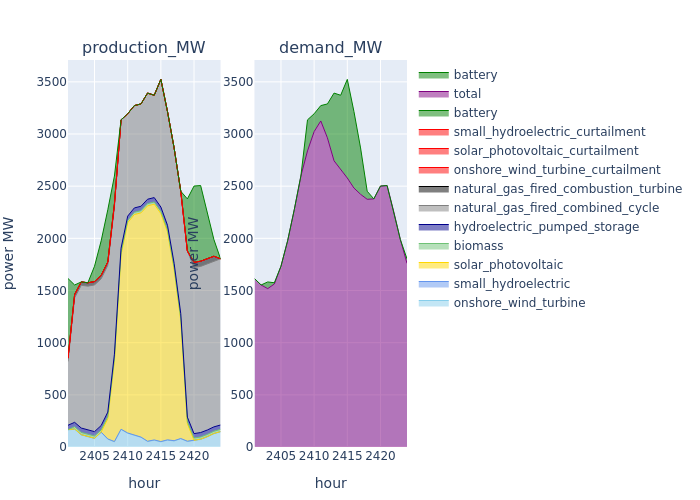

In [31]:
plot_supply_demand(supply, demand)

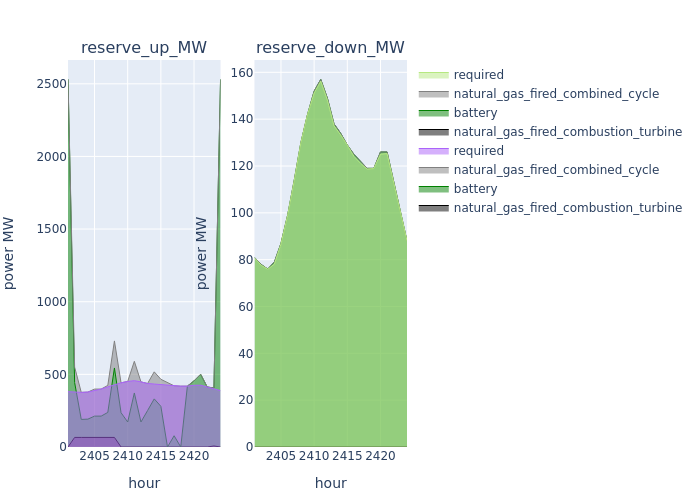

In [32]:
plot_reserve(reserve)

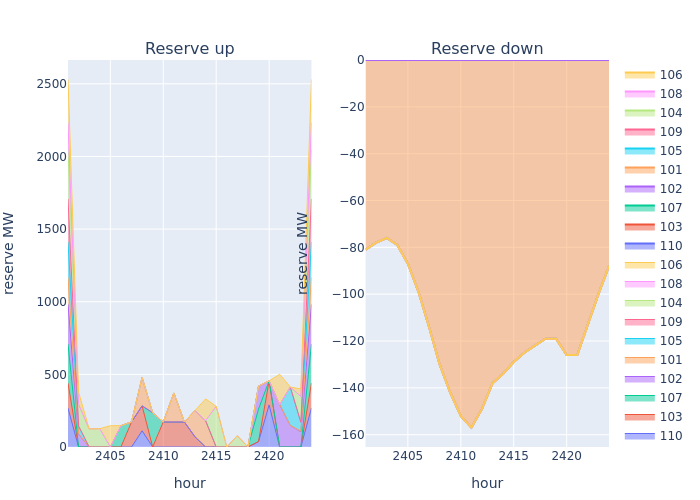

In [33]:
to_plot = reserve_[reserve_.resource .== "battery",:]
p1 = plot([scatter(
    x= to_plot[to_plot.r_id .== r,:].hour, y=to_plot[to_plot.r_id .== r,:].reserve_up_MW,
    stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
    line=attr(width=1, shape = "line")
) for r in unique(to_plot.r_id)],
Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve up"))

p2 = plot([scatter(
    x= to_plot[to_plot.r_id .== r,:].hour, y=-to_plot[to_plot.r_id .== r,:].reserve_down_MW,
    stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
    line=attr(width=2, shape = "line")
) for r in unique(to_plot.r_id)],
Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve down"))
p = [p1 p2]
relayout!(p)
p

### Energy reserve with storage R[t,t] = R[t], R[i,t] = 0 for i<t

In [34]:
required_energy_reserve = [(row_1.hour, row_2.hour, row_1.reserve_up_MW*(row_1.hour == row_2.hour), row_1.reserve_down_MW*(row_1.hour == row_2.hour)) for row_1 in eachrow(required_reserve), row_2 in eachrow(required_reserve) if row_1.hour <= row_2.hour]
required_energy_reserve = DataFrame(required_energy_reserve)
required_energy_reserve = rename(required_energy_reserve, :1 => :i_hour, :2 => :t_hour, :3 => :reserve_up_MW, :4 => :reserve_down_MW,)
;

In [35]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df,
    energy_reserve = required_energy_reserve,
    enriched_solution = true);
supply, demand = calculate_supply_demand(solution)
reserve_ = solution.energy_reserve[solution.energy_reserve.hour.==solution.energy_reserve.hour_i,:]
reserve = calculate_reserve(reserve_, required_reserve)
;

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding storage...
Adding ramp constraints...
Adding energy reserve constraints...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 39702 rows, 22920 columns and 303516 nonzeros
Model fingerprint: 0xcc3fb48f
Variable types: 21096 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 29738 rows and 19120 columns
Presolve time: 0.47s
Presolved: 9964 rows, 3800 columns, 128324 nonzeros
Variable types: 2020 continuous, 1780 integer (1780 binary)
Found heuristic solution: objective 1007630.3931

Root relaxation: objective 7.406420e+05, 2541 iterations, 0.20 sec

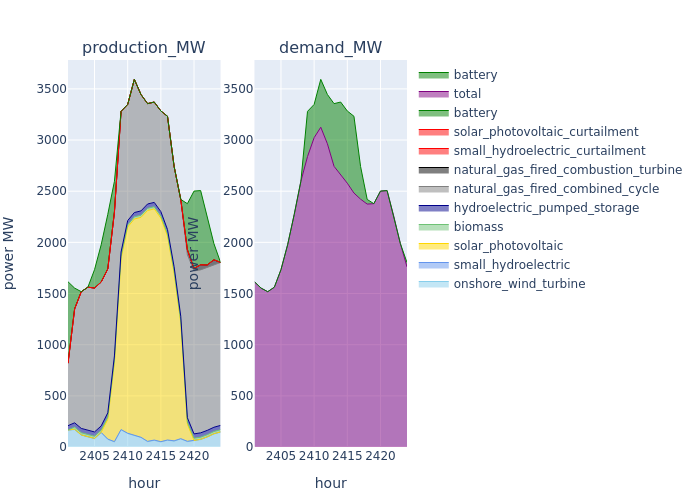

In [36]:
plot_supply_demand(supply, demand)


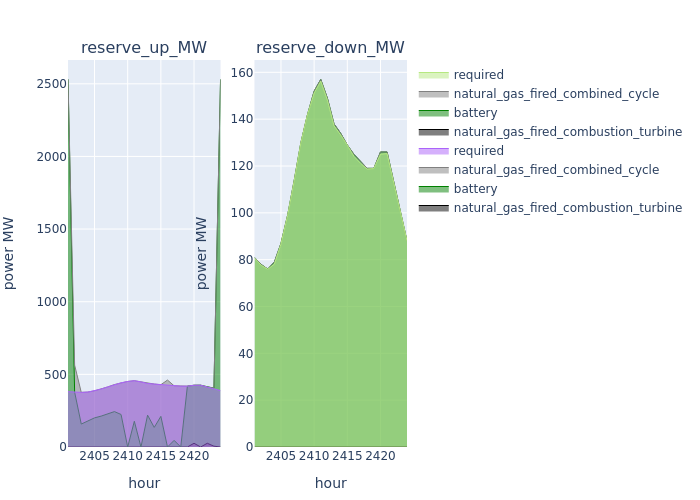

In [37]:
plot_reserve(reserve)

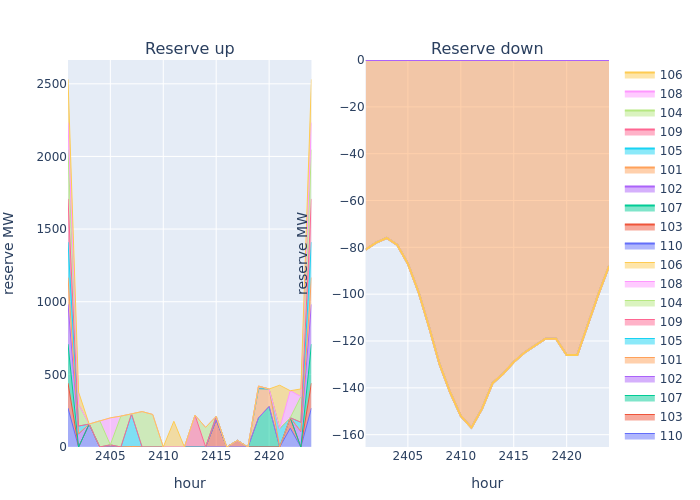

In [38]:
to_plot = reserve_[reserve_.resource .== "battery",:]
p1 = plot([scatter(
    x= to_plot[to_plot.r_id .== r,:].hour, y=to_plot[to_plot.r_id .== r,:].reserve_up_MW,
    stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
    line=attr(width=1, shape = "line")
) for r in unique(to_plot.r_id)],
Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve up"))

p2 = plot([scatter(
    x= to_plot[to_plot.r_id .== r,:].hour, y=-to_plot[to_plot.r_id .== r,:].reserve_down_MW,
    stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
    line=attr(width=2, shape = "line")
) for r in unique(to_plot.r_id)],
Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve down"))
p = [p1 p2]
relayout!(p)
p

### Energy reserve without storage

In [39]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    energy_reserve = required_energy_reserve,
    enriched_solution = true);
supply, demand = calculate_supply_demand(solution)
reserve_ = solution.energy_reserve[solution.energy_reserve.hour.==solution.energy_reserve.hour_i,:]
reserve = calculate_reserve(reserve_, required_reserve)
;

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...
Adding energy reserve constraints...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 31532 rows, 15960 columns and 281696 nonzeros
Model fingerprint: 0xeac0adb5
Variable types: 14376 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 22534 rows and 12692 columns
Presolve time: 0.60s
Presolved: 8998 rows, 3268 columns, 126488 nonzeros
Variable types: 1728 continuous, 1540 integer (1540 binary)

Root relaxation: objective 8.971854e+05, 2576 iterations, 0.19 seconds (0.20 work units)

    Nodes    |    Current

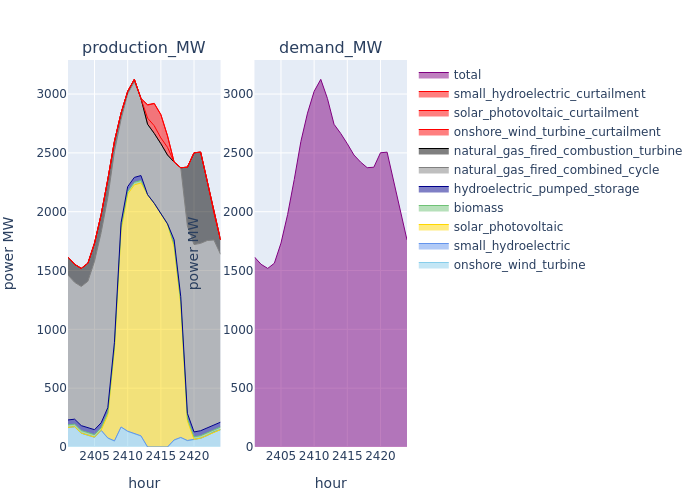

In [40]:
plot_supply_demand(supply, demand)

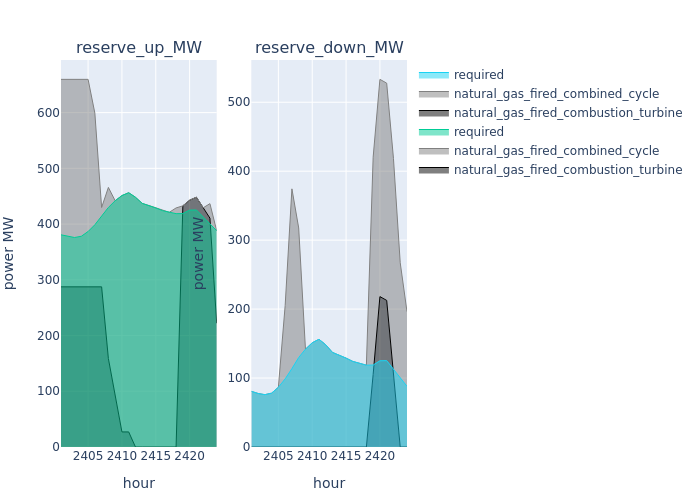

In [41]:
plot_reserve(reserve)

### Reserve provided by storage with envelopes

In [42]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df,
    storage_envelopes = true,
    reserve = required_reserve,
    enriched_solution = true);
supply, demand = calculate_supply_demand(solution)
reserve = calculate_reserve(solution.reserve, required_reserve)

# Reserve provided by bateries
aux1 = solution.storage[!,[:r_id, :hour, :envelope_up_MWh, :envelope_down_MWh, :SOE_MWh]]
aux2 = solution.reserve[solution.reserve.resource .=="battery",[:r_id, :hour, :reserve_up_MW, :reserve_down_MW]]
reserve_battery = innerjoin(aux1, aux2, on = [:r_id, :hour])
;

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding storage...
Adding ramp constraints...
Adding reserve constraints...


Adding storage envelopes...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 10782 rows, 5736 columns and 27136 nonzeros
Model fingerprint: 0xd388ec23
Variable types: 3912 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 6802 rows and 1182 columns
Presolve time: 0.05s
Presolved: 3980 rows, 4554 columns, 17832 nonzeros
Variable types: 2774 continuous, 1780 integer (1780 binary)
Found heuristic solution: objective 1003353.4281

Root relaxation: objective 7.447660e+05, 2191 iterations, 0.10 seconds (

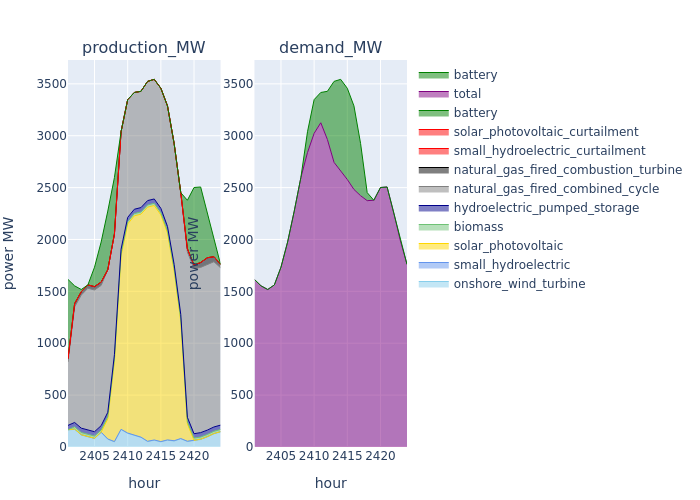

In [43]:
plot_supply_demand(supply, demand)

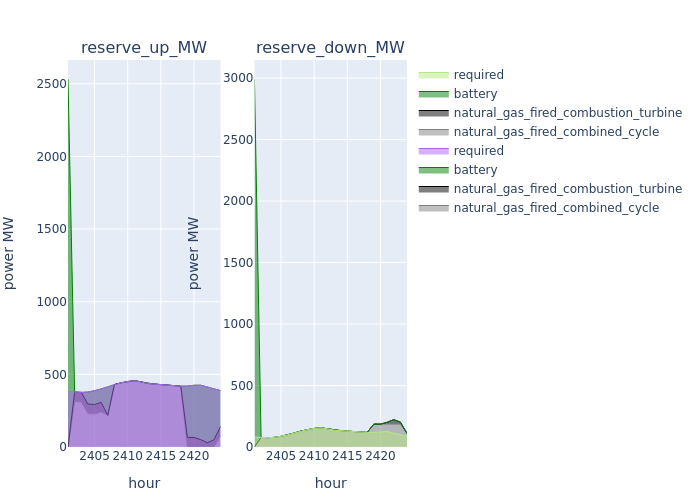

In [44]:
plot_reserve(reserve)

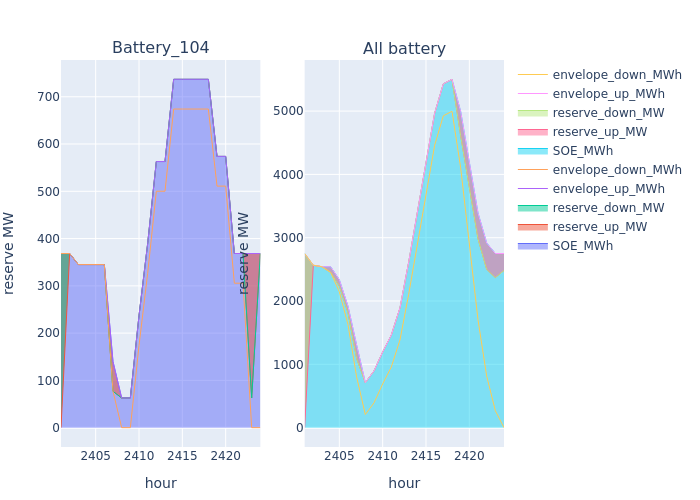

In [45]:
r = 104
efficiency = 0.92
reserve_keys = Dict(:up => :reserve_up_MW, :down => :reserve_down_MW)
single_battery = reserve_battery[reserve_battery.r_id .== r,:]
all_battery = combine(groupby(reserve_battery, :hour), Not(:hour) .=> sum, renamecols=false)
# to_plot.cum_reserve_up_MW = cumsum(to_plot.reserve_up_MW)
# to_plot.cum_reserve_down_MW = cumsum(to_plot.reserve_down_MW)
# reserve_keys = Dict(:up => :cum_reserve_up_MW, :down => :cum_reserve_down_MW)

reserves = [scatter(
    x= single_battery.hour, y=single_battery[!,key]*(+-1/efficiency*(key == reserve_keys[:up])+efficiency*(key == reserve_keys[:down]) +1 *(key == :SOE_MWh)),
    stackgroup=1, mode="lines", name = key,
    line=attr(width=1, shape = "line")
) for key in [:SOE_MWh, reserve_keys[:up], reserve_keys[:down]]]

envelope = [scatter(
    x= single_battery.hour, y=single_battery[!,key],
    mode="lines", name = key,
    line=attr(width=1, shape = "line")
) for key in [:envelope_up_MWh, :envelope_down_MWh]]
p1 = plot(union(reserves, envelope), Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Battery_"*string(r)))

reserves = [scatter(
    x= all_battery.hour, y=all_battery[!,key]*(+-1/efficiency*(key == reserve_keys[:up])+efficiency*(key == reserve_keys[:down]) +1 *(key == :SOE_MWh)),
    stackgroup=1, mode="lines", name = key,
    line=attr(width=1, shape = "line")
) for key in [:SOE_MWh, reserve_keys[:up], reserve_keys[:down]]]

envelope = [scatter(
    x= all_battery.hour, y=all_battery[!,key],
    mode="lines", name = key,
    line=attr(width=1, shape = "line")
) for key in [:envelope_up_MWh, :envelope_down_MWh]]
p2 = plot(union(reserves, envelope), Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "All battery"))

p = [p1 p2]
relayout!(p)
p

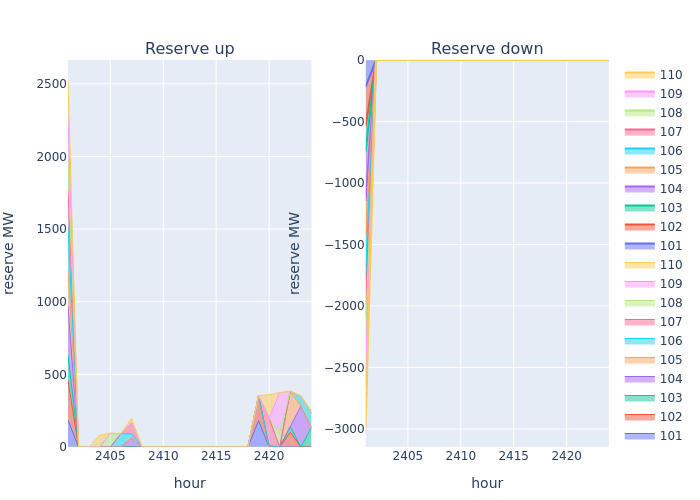

In [46]:
to_plot = solution.reserve[solution.reserve.resource .== "battery",:]
p1 = plot([scatter(
    x= to_plot[to_plot.r_id .== r,:].hour, y=to_plot[to_plot.r_id .== r,:].reserve_up_MW,
    stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
    line=attr(width=1, shape = "line")
) for r in unique(to_plot.r_id)],
Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve up"))

p2 = plot([scatter(
    x= to_plot[to_plot.r_id .== r,:].hour, y=-to_plot[to_plot.r_id .== r,:].reserve_down_MW,
    stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
    line=attr(width=2, shape = "line")
) for r in unique(to_plot.r_id)],
Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve down"))
p = [p1 p2]
relayout!(p)
p

### Reserve provided by storage

In [47]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df,
    storage_envelopes = false,
    reserve = required_reserve,
    enriched_solution = true);
supply, demand = calculate_supply_demand(solution)
reserve = calculate_reserve(solution.reserve, required_reserve)
;

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding storage...
Adding ramp constraints...
Adding reserve constraints...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 9342 rows, 5256 columns and 23836 nonzeros
Model fingerprint: 0x9464a893
Variable types: 3432 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 6242 rows and 1700 columns
Presolve time: 0.04s
Presolved: 3100 rows, 3556 columns, 14442 nonzeros
Variable types: 1776 continuous, 1780 integer (1780 binary)
Found heuristic solution: objective 1007595.4308

Root relaxation: objective 7.406420e+05, 1329 iterations, 0.03 seconds (0

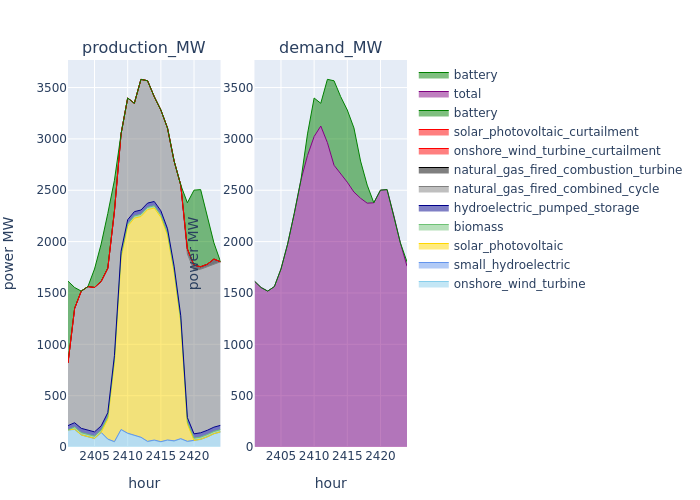

In [48]:
plot_supply_demand(supply, demand)

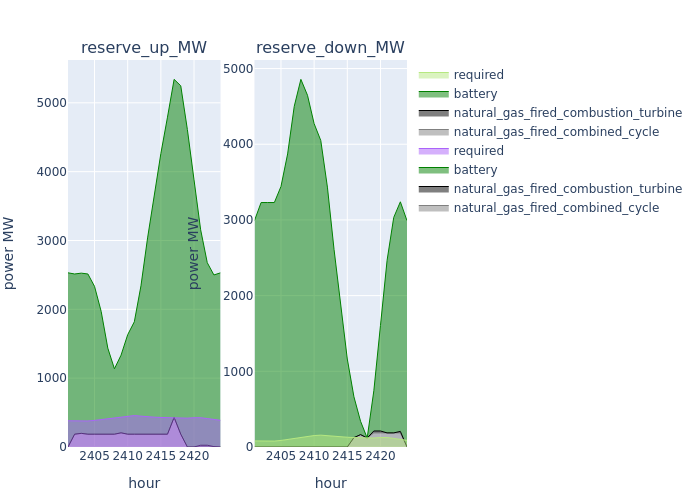

In [49]:
plot_reserve(reserve)

### End...